# Monte Carlo simulation of the 1D Ising Model

## Theory

The Ising model is model used in statistical physics to model a magnet.
It models magnetic dipole moments through $N$ "spins" $\sigma_i$ which can each take values $\{-1, +1\}$.
These spins are arranged in $n$-dimensional lattices with neighbouring spins able to act on each other.

The 1D model describes the model's configuration through vector $\boldsymbol{\sigma} = (\sigma_1, \sigma_2, \dots, \sigma_N)$.

Each configuration has energy $E(\boldsymbol{\sigma})$, which for the 1D model is given by:

$$E(\boldsymbol{\sigma}) = -J\sum_{\langle i, j \rangle}\sigma_i\sigma_j - h\sum_{i=1}^{N}\sigma_i$$

where $\langle i, j \rangle$ refers to pairs of adjacent spins (each pair is only counted once, includes $\langle N, 1 \rangle$ for periodic boudary conditions) and we assume both nearest neighbour interaction and external field strength, $J$ and $h$ respectively, are identical for all spins.

In the canonical ensemble, the Boltzmann distribution allows us to find the probability that configuration $\boldsymbol{\sigma}$ occurs at temperature $T$:

$$p(\boldsymbol{\sigma}|T) = \frac{1}{Z}\exp\bigg(-\frac{E(\boldsymbol{\sigma})}{T}\bigg)$$

where $Z$ is the partition function (normalisation constant).

Often, we are interested in the observed macro properties of systems which can be calculated by computing averages of observable quantities with respect to their probabilities (i.e. expected values).

Two properties which will be explored in this notebook are magnetisation and magnetic susceptibility.

The magnetisation of a configuration is:

$$\hat{M}(\boldsymbol{\sigma}) = \frac{1}{N}\sum_{i}\sigma_i$$

The average magnetisation of a system is:

$$M(T) = \sum_{\boldsymbol{\sigma}}\hat{M}(\boldsymbol{\sigma})p(\boldsymbol{\sigma}|T)$$

where terms are summed over all configurations.

The scaled magnetic susceptibility is $\chi(T) = T \frac{\partial M}{\partial h}$ and is related to the variance of $\hat{M}$ by the equation

$$\chi(T) = N \sum_{\boldsymbol{\sigma}}\big(\hat{M}(\boldsymbol{\sigma}) - M(T)\big)^2 p(\boldsymbol{\sigma}|T)$$

In the limit $N \rightarrow \infty$, transfer matrix methods can be used to show that:

$$M(T) = \sinh(h / T) \frac{\cosh(h / T) + \sqrt{\sinh^2(h / T) + e^{-4J/T}}}{\sinh^2(h / T) + e^{-4J/T} + \cosh(h/T)\sqrt{\sinh^2(h / T) + e^{-4J/T}}}$$

For $h=0$, we also have that:

$$\chi(T) = e^{2J/T}$$

## The Simulation

A Monte Carlo simulation will be used to generate a sequence of configurations to represent the Ising model.
These will be evolved stochastically as a function of time following a set of rules with the $t$-th configuration denoted by $\boldsymbol{\sigma}(t)$.

A configuration changes one spin at a time meaning it can be identical to its previous state or differ by exactly one spin.
To go from $\boldsymbol{\sigma}(t)$ to $\boldsymbol{\sigma}(t + 1)$, the following process is used:

1. Set $\boldsymbol{\sigma}(t + 1) = \boldsymbol{\sigma}(t)$
2. Choose a random integer $i$ between $1$ and $N$
3. Replace $\sigma_i(t + 1)$ with $-1$ or $1$ according to the following probabilities:
$$p[\sigma_i(t+1) = +1] = \frac{1}{1 + e^{-2\kappa_i / T}}$$
$$p[\sigma_i(t+1) = -1] = \frac{1}{1 + e^{2\kappa_i / T}}$$
where
$$\kappa_i = h + J(\sigma_{i + 1} + \sigma_{i - 1})$$

After sufficiently many updates, it is expected that the probability of the model ending in configuration $\boldsymbol{\sigma}$ converges to $p(\boldsymbol{\sigma}|T)$.
As such, it is useful to define rescaled time $\tau = t / N$ where $\tau$ represents the number of times $N$ updates have been performed.

In [421]:
import numpy as np
import random
import matplotlib.pyplot as plt
import time
from scipy.optimize import curve_fit
from numba import jit

In [422]:
@jit(nopython = True)
def UpdateProb(k, T):
    '''
    Function for prob(sigma_i(t + 1) = +1).
    Note that:
    prob(sigma_i(t + 1) = -1) = 1 - prob(sigma_i(t + 1) = +1)
    '''
    if T == 0: # ZeroDivisionError
        if k > 0:
            return 1
        elif k == 0:
            return 0.5
        elif k < 0:
            return 0
    else:
        return (1 + np.exp(-2 * k / T)) ** (-1)

In [423]:
@jit(nopython = True)
def UpdateConfig(n, Sigma, h, J, T):
    '''
    n = number of updates to perform
    Sigma = configuration array to be updated
    h = magnetisation constant
    J = interaction constant
    T = temperature
    '''
    for i in range(n):
        # Choose random spin to update
        m = random.randint(0, len(Sigma) - 1)
        # Choose random probability value from uniform distrib
        p_rng = random.uniform(0, 1)
        # To fulfil periodic bounary conditions
        if m == (len(Sigma) - 1):
            k = h + J * (Sigma[0] + Sigma[-2])
            p_plus = UpdateProb(k, T)
            if p_rng <= p_plus:
                Sigma[m] = 1
            else:
                Sigma[m] = -1
        else:
            k = h + J * (Sigma[m - 1] + Sigma[m + 1])
            p_plus = UpdateProb(k, T)
            if p_rng <= p_plus:
                Sigma[m] = 1
            else:
                Sigma[m] = -1
        
    return Sigma

## Methodology

The program will proceed as follows:

1. The initial state $\boldsymbol{\sigma}(0)$ will be a vector of ones (i.e. $\sigma_i = +1$  $\forall i$).
2. Define parameter $n_w$ as the number of "warm-ups" and perform $n_w \times N$ updates of the system. After warming up, the rescaled time is $\tau = n_w$.
3. Set a counter $k = 1$ in units of a new rescaled time $n_I$ and define parameter $K$. 
4. Compute and store the magnetisation of the configuration at time current time $t$ as
$$ M_k = \frac{1}{N}\sum_{i}\sigma_i(t) $$
5. Update for another period of rescaled time, increasing the counter for $k$ by 1.
6. Repeat steps 4 and 5 until $k = K$.
7. Compute the average magnetisation across $M_1, M_2, \dots, M_K$ as well as a scaled measure of their variance:
$$ \bar{M} = \frac{1}{K}\sum_{k = 1}^{K}M_k $$
$$ \hat{\chi} = \frac{N}{K}\sum_{k = 1}^{K}(M_k - \bar{M})^2 $$

Assuming $K$ and $n_w$ are large enough, it is expected $\bar{M}$ and $\hat{\chi}$ should be good estimates of the equilibrium magnetisation and susceptibility of the system as defined earlier.

In [424]:
@jit(nopython = True)
def M_config(Sigma):
    # Sigma = configuration array
    return np.average(Sigma)

In [425]:
@jit(nopython = True)
def M_bar_sys(M):
    # M = array containing configuration magnetisation values
    return np.average(M)

In [426]:
@jit(nopython = True)
def chi_hat(M, N):
    # M = array containing configuration magnetisation values
    return N * np.var(M)

## Testing the model

### Settings 1 $(h = 0.1, J = 1)$

In [427]:
random.seed(10)

N = 100 # try 50, 100
n_w = int(1e4)
n_I = 5
K = 4096 # try 1024, 2048, 4096
h = 0.1
J = 1
beta = np.linspace(0, 2, 101)
M_beta = np.full(len(beta), float("nan"))
Var_M_beta = np.full(len(beta), float("nan"))

#### Running the simulation $(h = 0.1, J = 1)$

In [428]:
# '''
# Estimated execution times
# ~0.47 sec (N = 50, K = 1024)
# ~6.65 sec (N = 100, K = 1024)
# ~8.07 sec (N = 100, K = 2048)
# ~12.66 sec (N = 100, K = 4096)
# '''

# t_start = time.time()

# for b in range(len(beta)):
#     # Initialise configuration array
#     Sigma = np.ones(N)
#     M_Sigma = np.full(K, float("nan"))
#     # Warm-up
#     if beta[b] == 0:
#         UpdateConfig(n_w * N, Sigma, h, J, np.inf)
#     else:
#         UpdateConfig(n_w * N, Sigma, h, J, 1 / beta[b])

#     # Sampling
#     for k in range(K):
#         M_Sigma[k] = M_config(Sigma)
#         if beta[b] == 0:
#             UpdateConfig(n_I * N, Sigma, h, J, np.inf)
#         else:
#             UpdateConfig(n_I * N, Sigma, h, J, 1 / beta[b])
    
#     # Store results per beta
#     M_beta[b] = M_bar_sys(M_Sigma)
#     Var_M_beta[b] = chi_hat(M_Sigma, N)

# t_end = time.time()

# t_elapsed = t_end - t_start
# print("Execution time = ", t_elapsed, " seconds.")

In [429]:
# # Save data as .npy file for later use to save time if desired
# file_name = "data_N%i_K%i_h%.1f_J%i.npy" %(N, K, h, J)
# np.save(file_name, np.stack((beta, M_beta, Var_M_beta)))

#### Visualisations and verification $(h = 0.1, J = 1)$

In [430]:
# Load data from .npy file if required
N = 100
K = 4096
data = np.load("data_N%i_K%i_h%.1f_J%i.npy" %(N, K, h, J))
beta = data[0]
M_beta = data[1]
Var_M_beta = data[2]

##### Plot $\bar{M}$ vs $\beta$ $(h = 0.1, J = 1)$

Can check simulated values and compare to expected analytic function.

In the limit $N \rightarrow \infty$, transfer matrix methods can be used to show that:

$$M(T) = \sinh(h / T) \frac{\cosh(h / T) + \sqrt{\sinh^2(h / T) + e^{-4J/T}}}{\sinh^2(h / T) + e^{-4J/T} + \cosh(h/T)\sqrt{\sinh^2(h / T) + e^{-4J/T}}}$$

In [431]:
@jit(nopython = True)
def M_analyt_beta(beta, h, J):
    return (
        np.sinh(h * beta) 
        * (np.cosh(h * beta) + np.sqrt(np.sinh(h * beta) ** 2 + np.exp(-4 * J * beta)))
        / (np.sinh(h * beta) ** 2 + np.exp(-4 * J * beta) 
           + np.cosh(h * beta) * np.sqrt(np.sinh(h * beta) ** 2 + np.exp( -4 * J * beta)))
           )

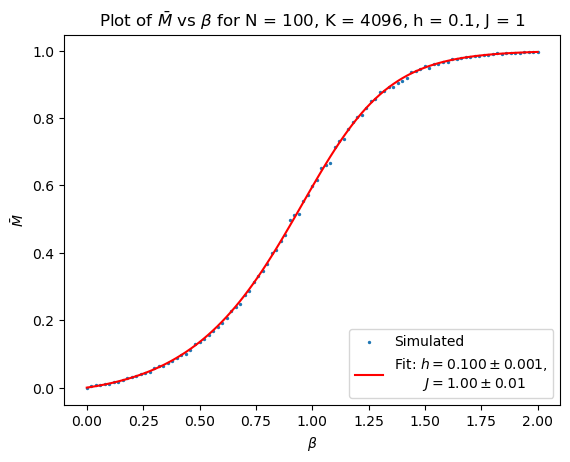

In [432]:
fig_M_bar = plt.figure()

plt.scatter(beta, M_beta, s=2, label = "Simulated")

popt, pcov = curve_fit(M_analyt_beta, beta, M_beta)
perr = np.sqrt(np.diag(pcov)) # compute one stdev error on params
params = np.stack((popt, perr))
plt.plot(beta, M_analyt_beta(beta, *popt), 'r-', 
         label = r"Fit: $h = %.3f \pm %.3f$," "\n" "       $J = %.2f \pm %.2f$" 
         % tuple(np.ravel(params, order = 'F')))

plt.title(r"Plot of $\bar{M}$ vs $\beta$ for N = %i, K = %i, h = %.1f, J = %i" %(N, K, h, J))
plt.xlabel(r"$\beta$")
plt.ylabel(r"$\bar{M}$")
plt.legend(loc = "lower right")

plt.show()

##### Plot $\hat{\chi}$ vs $\beta$ $(h = 0.1, J = 1)$

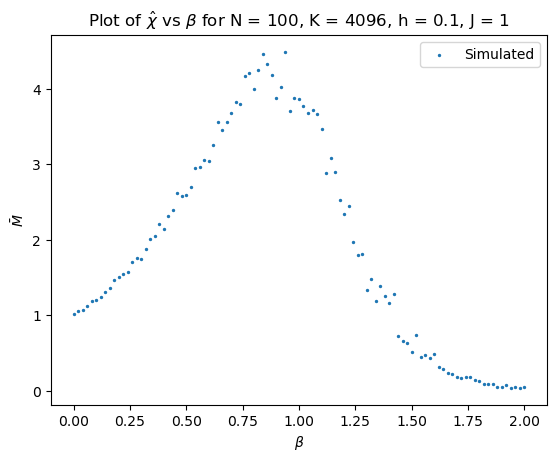

In [433]:
fig_Var = plt.figure()
plt.scatter(beta, Var_M_beta, s=2, label = "Simulated")
plt.title(r"Plot of $\hat{\chi}$ vs $\beta$ for N = %i, K = %i, h = %.1f, J = %i" %(N, K, h, J))
plt.xlabel(r"$\beta$")
plt.ylabel(r"$\bar{M}$")
plt.legend(loc = "upper right")

plt.show()

##### Check $\bar{M}$ value consistency across simulations $(h = 0.1, J = 1)$

In [434]:
'''
Estimated execution times
~0.25 sec (N = 50, K = 1024)
~1 sec (N = 100, K = 4096)
'''

t_start = time.time()
trials = 10
beta_trial = 1.56 # Choose random value for beta in test range 0 - 2
M_check = np.full(trials, float("nan"))
Var_M_check = np.full(trials, float("nan"))

for i in range(trials):
    # Initialise configuration array
    Sigma = np.ones(N)
    M_Sigma = np.full(K, float("nan"))
    # Warm-up
    if beta_trial == 0:
        UpdateConfig(n_w * N, Sigma, h, J, np.inf)
    else:
        UpdateConfig(n_w * N, Sigma, h, J, 1 / beta_trial)

    # Sampling
    for k in range(K):
        M_Sigma[k] = M_config(Sigma)
        if beta_trial == 0:
            UpdateConfig(n_I * N, Sigma, h, J, np.inf)
        else:
            UpdateConfig(n_I * N, Sigma, h, J, 1 / beta_trial)
    
    # Store results per trial
    M_check[i] = M_bar_sys(M_Sigma)
    Var_M_check[i] = chi_hat(M_Sigma, N)

t_end = time.time()

t_elapsed = t_end - t_start
print("Execution time = ", t_elapsed, " seconds.")

Execution time =  1.1343345642089844  seconds.


In [435]:
# Trial report
print("For beta = %.2f" %beta_trial)
print("The average calculated system magnetisation = %.5f ± %.5f" 
      %(np.mean(M_check), np.var(M_check)))
print(r"The average calculated system magnetic susceptibility = %.2f ± %.2f" 
      %(np.mean(Var_M_check), np.var(Var_M_check)))

For beta = 1.56
The average calculated system magnetisation = 0.96262 ± 0.00001
The average calculated system magnetic susceptibility = 0.44 ± 0.00


#### Error analysis $(h = 0.1, J = 1)$

Estimate error bars from the variances of $\bar{M}$ and $\hat{\chi}$ across several simulations.

In [436]:
# '''
# Estimated execution times
# ~30 sec (N = 50, K = 1024)
# ~2 min 20 sec (N = 100, K = 4096)
# '''

# t_start = time.time()
# trials = 10
# # beta is from previously loaded/simulated data
# M_beta_per_trial = np.full((trials, len(beta)), float("nan"))
# # M_beta_per_trial[i][j] = (i-1)th trial for beta = beta[j]
# Var_M_beta_per_trial = np.full((trials, len(beta)), float("nan"))
# # Var_M_beta_per_trial[i][j] = (i-1)th trial for beta = beta[j]

# for i in range(trials):
#     for b in range(len(beta)):
#         # Initialise configuration array
#         Sigma = np.ones(N)
#         M_Sigma = np.full(K, float("nan"))
#         # Warm-up
#         if beta[b] == 0:
#             UpdateConfig(n_w * N, Sigma, h, J, np.inf)
#         else:
#             UpdateConfig(n_w * N, Sigma, h, J, 1 / beta[b])

#         # Sampling
#         for k in range(K):
#             M_Sigma[k] = M_config(Sigma)
#             if beta[b] == 0:
#                 UpdateConfig(n_I * N, Sigma, h, J, np.inf)
#             else:
#                 UpdateConfig(n_I * N, Sigma, h, J, 1 / beta[b])

#         # Store results per beta
#         M_beta_per_trial[i][b] = M_bar_sys(M_Sigma)
#         Var_M_beta_per_trial[i][b] = chi_hat(M_Sigma, N)

# t_end = time.time()

# t_elapsed = t_end - t_start
# print("Execution time = ", t_elapsed, " seconds.")

It is highly recommended to save data to load up for later use due to the time it can take to run this simulation.

In [437]:
# # Save data as .npy file for later use to save time if desired
# file_name_beta = "data_N%i_K%i_h%.1f_J%i_beta.npy" %(N, K, h, J)
# file_name_M_multi = "data_N%i_K%i_h%.1f_J%i_M_multi.npy" %(N, K, h, J)
# file_name_Var_M_multi = "data_N%i_K%i_h%.1f_J%i_Var_M_multi.npy" %(N, K, h, J)
# np.save(file_name_beta, beta)
# np.save(file_name_M_multi, M_beta_per_trial)
# np.save(file_name_Var_M_multi, Var_M_beta_per_trial)

#### Plots including error bars $(h = 0.1, J = 1)$

In [438]:
# Load data from .npy file if required
N = 100
K = 4096
beta = np.load("data_N%i_K%i_h%.1f_J%i_beta.npy" %(N, K, h, J))
M_beta_per_trial = np.load("data_N%i_K%i_h%.1f_J%i_M_multi.npy" %(N, K, h, J))
Var_M_beta_per_trial = np.load("data_N%i_K%i_h%.1f_J%i_Var_M_multi.npy" %(N, K, h, J))

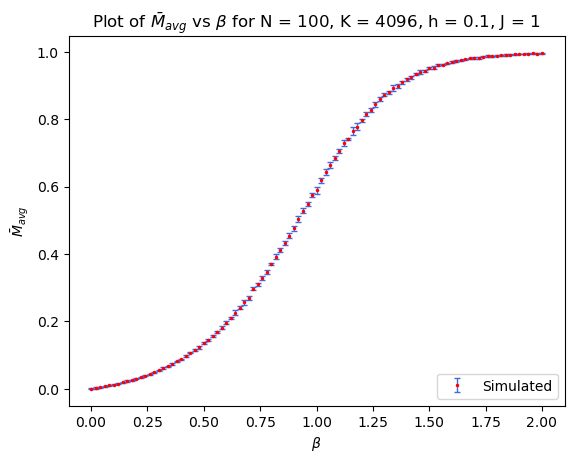

In [439]:
M_avg = np.average(M_beta_per_trial, axis = 0)
M_error = np.std(M_beta_per_trial, axis = 0)

fig_M_bar_error = plt.figure()

plt.errorbar(beta, M_avg, yerr = M_error,  ls = 'none',
             fmt = 'ro', markersize = 1.5,
             elinewidth = 1, ecolor = 'royalblue', capsize = 2,
             label = "Simulated")

# popt_avg, pcov_avg = curve_fit(M_analyt_beta, beta, M_avg)
# perr_avg = np.sqrt(np.diag(pcov_avg)) # compute one stdev error on params
# params_avg = np.stack((popt_avg, perr_avg))
# plt.plot(beta, M_analyt_beta(beta, *popt_avg), 'g-', 
#          label = r"Fit: $h = %.3f \pm %.3f$," "\n" "       $J = %.2f \pm %.2f$" 
#          % tuple(np.ravel(params_avg, order = 'F')))

plt.title(r"Plot of $\bar{M}_{avg}$ vs $\beta$ for N = %i, K = %i, h = %.1f, J = %i" %(N, K, h, J))
plt.xlabel(r"$\beta$")
plt.ylabel(r"$\bar{M}_{avg}$")
plt.legend(loc = "lower right")

plt.show()

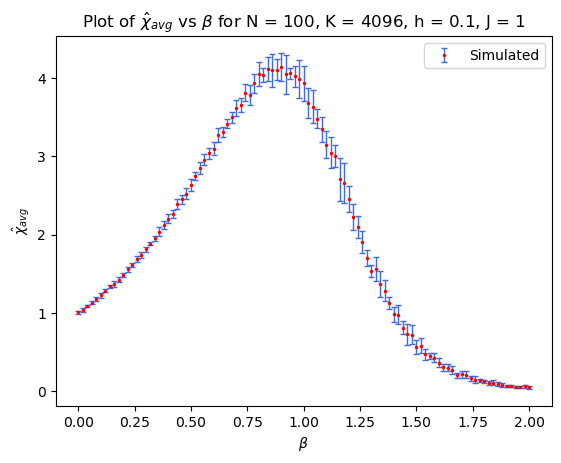

In [440]:
Var_M_avg = np.average(Var_M_beta_per_trial, axis = 0)
Var_M_error = np.std(Var_M_beta_per_trial, axis = 0)

fig_Var_error = plt.figure()

plt.errorbar(beta, Var_M_avg, yerr = Var_M_error,  ls = 'none',
             fmt = 'ro', markersize = 1.5,
             elinewidth = 1, ecolor = 'royalblue', capsize = 2,
             label = "Simulated")

plt.title(r"Plot of $\hat{\chi}_{avg}$ vs $\beta$ for N = %i, K = %i, h = %.1f, J = %i" %(N, K, h, J))
plt.xlabel(r"$\beta$")
plt.ylabel(r"$\hat{\chi}_{avg}$")
plt.legend(loc = "upper right")

plt.show()

### Settings 2 $(h = 0, J = 1)$

In [441]:
random.seed(10)

N = 100 # try 50, 100
n_w = int(1e4)
n_I = 5
K = 4096 # try 1024, 2048, 4096
h = 0
J = 1
beta = np.linspace(0, 3, 301)
M_beta = np.full(len(beta), float("nan"))
Var_M_beta = np.full(len(beta), float("nan"))

#### Running the simulation $(h = 0, J = 1)$

In [442]:
# '''
# Estimated execution times
# ~0.47 sec (N = 50, K = 1024)
# ~6.65 sec (N = 100, K = 1024)
# ~8.07 sec (N = 100, K = 2048)
# ~46 sec (N = 100, K = 4096)
# '''

# t_start = time.time()

# for b in range(len(beta)):
#     # Initialise configuration array
#     Sigma = np.ones(N)
#     M_Sigma = np.full(K, float("nan"))
#     # Warm-up
#     if beta[b] == 0:
#         UpdateConfig(n_w * N, Sigma, h, J, np.inf)
#     else:
#         UpdateConfig(n_w * N, Sigma, h, J, 1 / beta[b])

#     # Sampling
#     for k in range(K):
#         M_Sigma[k] = M_config(Sigma)
#         if beta[b] == 0:
#             UpdateConfig(n_I * N, Sigma, h, J, np.inf)
#         else:
#             UpdateConfig(n_I * N, Sigma, h, J, 1 / beta[b])
    
#     # Store results per beta
#     M_beta[b] = M_bar_sys(M_Sigma)
#     Var_M_beta[b] = chi_hat(M_Sigma, N)

# t_end = time.time()

# t_elapsed = t_end - t_start
# print("Execution time = ", t_elapsed, " seconds.")

In [443]:
# # Save data as .npy file for later use to save time if desired
# file_name = "data_N%i_K%i_h%.1f_J%i.npy" %(N, K, h, J)
# np.save(file_name, np.stack((beta, M_beta, Var_M_beta)))

#### Visualisations and verification $(h = 0, J = 1)$

In [444]:
# Load data from .npy file if required
N = 100
K = 4096
data = np.load("data_N%i_K%i_h%.1f_J%i.npy" %(N, K, h, J))
beta = data[0]
M_beta = data[1]
Var_M_beta = data[2]

##### Plot $\bar{M}$ vs $\beta$ $(h = 0, J = 1)$

Can check simulated values and compare to expected analytic function.

For $h=0$, we have that:

$$M(T) \rightarrow 0$$

$$\chi(T) = e^{2J/T}$$

In [445]:
@jit(nopython = True)
def chi_analyt(beta, J):
    return (np.exp(2 * J * beta))

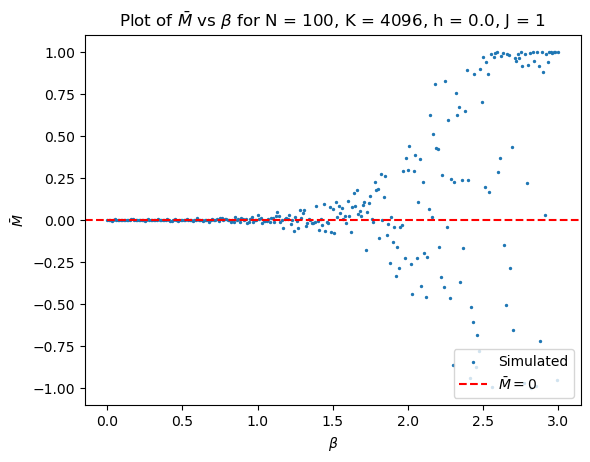

In [446]:
fig_M_bar = plt.figure()

plt.scatter(beta, M_beta, s=2, label = "Simulated")
plt.axhline(0, c = 'r', ls = '--', label = r"$\bar{M} = 0$")

plt.title(r"Plot of $\bar{M}$ vs $\beta$ for N = %i, K = %i, h = %.1f, J = %i" %(N, K, h, J))
plt.xlabel(r"$\beta$")
plt.ylabel(r"$\bar{M}$")
plt.legend(loc = "lower right")

plt.show()

##### Plot $\hat{\chi}$ vs $\beta$ $(h = 0, J = 1)$

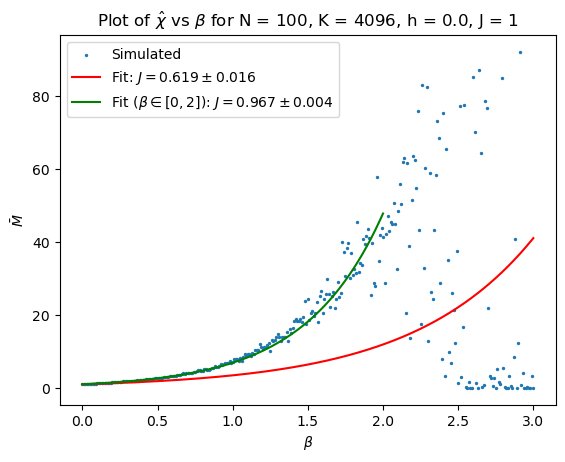

In [447]:
fig_Var = plt.figure()

plt.scatter(beta, Var_M_beta, s=2, label = "Simulated")

popt_chi, pcov_chi = curve_fit(chi_analyt, beta, Var_M_beta)
perr_chi = np.sqrt(np.diag(pcov_chi)) # compute one stdev error on params
plt.plot(beta, chi_analyt(beta, *popt_chi), 'r-', 
         label = r"Fit: $J = %.3f \pm %.3f$"
         % (popt_chi, perr_chi))

popt_chi_trunc, pcov_chi_trunc = curve_fit(
    chi_analyt, beta[:201], Var_M_beta[:201])
perr_chi_trunc = np.sqrt(np.diag(pcov_chi_trunc)) # compute one stdev error on params
plt.plot(beta[:201], chi_analyt(beta[:201], *popt_chi_trunc), 'g-', 
         label = r"Fit $(\beta \in [0, 2])$: $J = %.3f \pm %.3f$"
         % (popt_chi_trunc, perr_chi_trunc))

plt.title(r"Plot of $\hat{\chi}$ vs $\beta$ for N = %i, K = %i, h = %.1f, J = %i" %(N, K, h, J))
plt.xlabel(r"$\beta$")
plt.ylabel(r"$\bar{M}$")
plt.legend(loc = "upper left")

plt.show()

##### Check $\bar{M}$ value consistency across simulations $(h = 0, J = 1)$

In [448]:
'''
Estimated execution times
~0.25 sec (N = 50, K = 1024)
~1 sec (N = 100, K = 4096)
'''

t_start = time.time()
trials = 10
beta_trial = 1.56 # Choose random value for beta in test range 0 - 2
M_check = np.full(trials, float("nan"))
Var_M_check = np.full(trials, float("nan"))

for i in range(trials):
    # Initialise configuration array
    Sigma = np.ones(N)
    M_Sigma = np.full(K, float("nan"))
    # Warm-up
    if beta_trial == 0:
        UpdateConfig(n_w * N, Sigma, h, J, np.inf)
    else:
        UpdateConfig(n_w * N, Sigma, h, J, 1 / beta_trial)

    # Sampling
    for k in range(K):
        M_Sigma[k] = M_config(Sigma)
        if beta_trial == 0:
            UpdateConfig(n_I * N, Sigma, h, J, np.inf)
        else:
            UpdateConfig(n_I * N, Sigma, h, J, 1 / beta_trial)
    
    # Store results per trial
    M_check[i] = M_bar_sys(M_Sigma)
    Var_M_check[i] = chi_hat(M_Sigma, N)

t_end = time.time()

t_elapsed = t_end - t_start
print("Execution time = ", t_elapsed, " seconds.")

Execution time =  1.0810344219207764  seconds.


In [449]:
# Trial report
print("For beta = %.2f" %beta_trial)
print("The average calculated system magnetisation = %.5f ± %.5f" 
      %(np.mean(M_check), np.var(M_check)))
print(r"The average calculated system magnetic susceptibility = %.2f ± %.2f" 
      %(np.mean(Var_M_check), np.var(Var_M_check)))

For beta = 1.56
The average calculated system magnetisation = -0.00183 ± 0.00380
The average calculated system magnetic susceptibility = 23.01 ± 17.42


#### Error analysis $(h = 0, J = 1)$

Estimate error bars from the variances of $\bar{M}$ and $\hat{\chi}$ across several simulations.

In [450]:
# '''
# Estimated execution times
# ~30 sec (N = 50, K = 1024)
# ~ 7 min (N = 100, K = 4096)
# '''

# t_start = time.time()
# trials = 10
# # beta is from previously loaded/simulated data
# M_beta_per_trial = np.full((trials, len(beta)), float("nan"))
# # M_beta_per_trial[i][j] = (i-1)th trial for beta = beta[j]
# Var_M_beta_per_trial = np.full((trials, len(beta)), float("nan"))
# # Var_M_beta_per_trial[i][j] = (i-1)th trial for beta = beta[j]

# for i in range(trials):
#     for b in range(len(beta)):
#         # Initialise configuration array
#         Sigma = np.ones(N)
#         M_Sigma = np.full(K, float("nan"))
#         # Warm-up
#         if beta[b] == 0:
#             UpdateConfig(n_w * N, Sigma, h, J, np.inf)
#         else:
#             UpdateConfig(n_w * N, Sigma, h, J, 1 / beta[b])

#         # Sampling
#         for k in range(K):
#             M_Sigma[k] = M_config(Sigma)
#             if beta[b] == 0:
#                 UpdateConfig(n_I * N, Sigma, h, J, np.inf)
#             else:
#                 UpdateConfig(n_I * N, Sigma, h, J, 1 / beta[b])

#         # Store results per beta
#         M_beta_per_trial[i][b] = M_bar_sys(M_Sigma)
#         Var_M_beta_per_trial[i][b] = chi_hat(M_Sigma, N)

# t_end = time.time()

# t_elapsed = t_end - t_start
# print("Execution time = ", t_elapsed, " seconds.")

It is highly recommended to save data to load up for later use due to the time it can take to run this simulation.

In [451]:
# # Save data as .npy file for later use to save time if desired
# file_name_beta = "data_N%i_K%i_h%.1f_J%i_beta.npy" %(N, K, h, J)
# file_name_M_multi = "data_N%i_K%i_h%.1f_J%i_M_multi.npy" %(N, K, h, J)
# file_name_Var_M_multi = "data_N%i_K%i_h%.1f_J%i_Var_M_multi.npy" %(N, K, h, J)
# np.save(file_name_beta, beta)
# np.save(file_name_M_multi, M_beta_per_trial)
# np.save(file_name_Var_M_multi, Var_M_beta_per_trial)

#### Plots including error bars $(h = 0, J = 1)$

In [452]:
# Load data from .npy file if required
N = 100
K = 4096
beta = np.load("data_N%i_K%i_h%.1f_J%i_beta.npy" %(N, K, h, J))
M_beta_per_trial = np.load("data_N%i_K%i_h%.1f_J%i_M_multi.npy" %(N, K, h, J))
Var_M_beta_per_trial = np.load("data_N%i_K%i_h%.1f_J%i_Var_M_multi.npy" %(N, K, h, J))

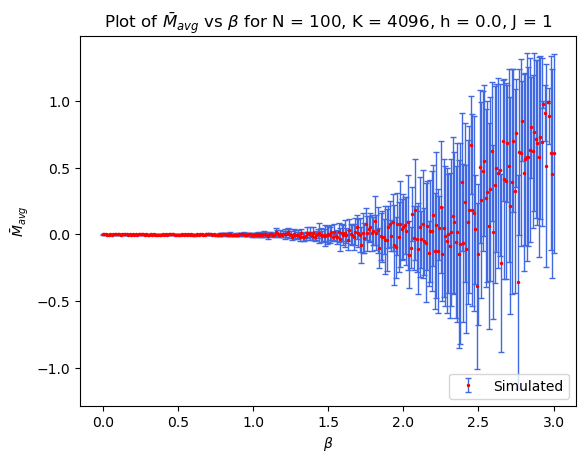

In [453]:
M_avg = np.average(M_beta_per_trial, axis = 0)
M_error = np.std(M_beta_per_trial, axis = 0)

fig_M_bar_error = plt.figure()

plt.errorbar(beta, M_avg, yerr = M_error,  ls = 'none',
             fmt = 'ro', markersize = 1.5,
             elinewidth = 1, ecolor = 'royalblue', capsize = 2,
             label = "Simulated")

plt.title(r"Plot of $\bar{M}_{avg}$ vs $\beta$ for N = %i, K = %i, h = %.1f, J = %i" %(N, K, h, J))
plt.xlabel(r"$\beta$")
plt.ylabel(r"$\bar{M}_{avg}$")
plt.legend(loc = "lower right")

plt.show()

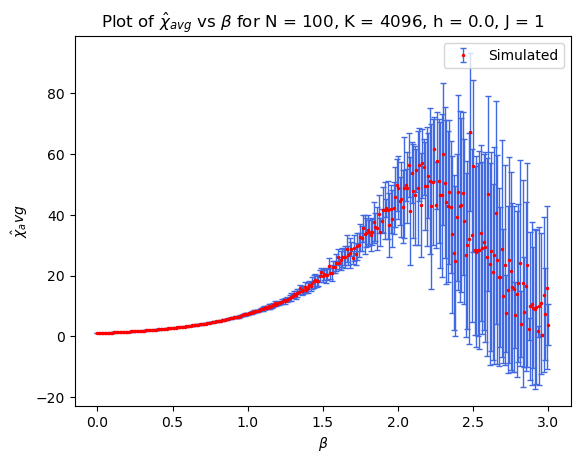

In [454]:
Var_M_avg = np.average(Var_M_beta_per_trial, axis = 0)
Var_M_error = np.std(Var_M_beta_per_trial, axis = 0)

fig_Var_error = plt.figure()

plt.errorbar(beta, Var_M_avg, yerr = Var_M_error,  ls = 'none',
             fmt = 'ro', markersize = 1.5,
             elinewidth = 1, ecolor = 'royalblue', capsize = 2,
             label = "Simulated")

plt.title(r"Plot of $\hat{\chi}_{avg}$ vs $\beta$ for N = %i, K = %i, h = %.1f, J = %i" %(N, K, h, J))
plt.xlabel(r"$\beta$")
plt.ylabel(r"$\hat{\chi}_avg$")
plt.legend(loc = "upper right")

plt.show()

### Settings 3 $(J = 1, T = 1.5)$

In [455]:
random.seed(10)

N = 100 # try 50, 100
n_w = int(1e4)
n_I = 5
K = 4096 # try 1024, 2048, 4096
h = np.linspace(-1, 1, 201)
J = 1
T = 1.5
beta = 1 / T
M_h = np.full(len(h), float("nan"))
Var_M_h = np.full(len(h), float("nan"))

#### Running the simulation $(h = 0, J = 1)$

In [456]:
# '''
# Estimated execution times
# ~24 sec (N = 100, K = 4096)

# '''

# t_start = time.time()

# for H in range(len(h)):
#     # Initialise configuration array
#     Sigma = np.ones(N)
#     M_Sigma = np.full(K, float("nan"))
#     # Warm-up
#     UpdateConfig(n_w * N, Sigma, h[H], J, T)

#     # Sampling
#     for k in range(K):
#         M_Sigma[k] = M_config(Sigma)
#         UpdateConfig(n_I * N, Sigma, h[H], J, T)
    
#     # Store results per beta
#     M_h[H] = M_bar_sys(M_Sigma)
#     Var_M_h[H] = chi_hat(M_Sigma, N)

# t_end = time.time()

# t_elapsed = t_end - t_start
# print("Execution time = ", t_elapsed, " seconds.")

In [457]:
# # Save data as .npy file for later use to save time if desired
# file_name = "data_N%i_K%i_J%i_T%.1f.npy" %(N, K, J, T)
# np.save(file_name, np.stack((h, M_h, Var_M_h)))

#### Visualisations and verification $(h = 0, J = 1)$

In [458]:
# Load data from .npy file if required
N = 100
K = 4096
data = np.load("data_N%i_K%i_J%i_T%.1f.npy" %(N, K, J, T))
h = data[0]
M_h = data[1]
Var_M_h = data[2]

##### Plot $\bar{M}$ vs $\beta$ $(h = 0, J = 1)$

Can check simulated values and compare to expected analytic function.

For $h=0$, we have that:

$$M(T) \rightarrow 0$$

$$\chi(T) = e^{2J/T}$$

In [459]:
@jit(nopython = True)
def M_analyt_h(h, T, J):
    return (
        np.sinh(h / T) 
        * (np.cosh(h / T) + np.sqrt(np.sinh(h / T) ** 2 + np.exp(-4 * J / T)))
        / (np.sinh(h / T) ** 2 + np.exp(-4 * J / T) 
           + np.cosh(h / T) * np.sqrt(np.sinh(h / T) ** 2 + np.exp( -4 * J / T)))
           )

In [460]:
@jit(nopython = True)
def chi_analyt(beta, J):
    return (np.exp(2 * J * beta))

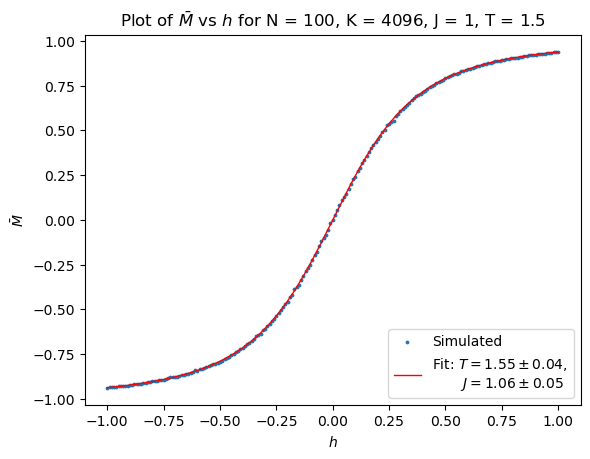

In [461]:
fig_M_bar = plt.figure()

plt.scatter(h, M_h, s=3, label = "Simulated")

popt_M, pcov_M = curve_fit(M_analyt_h, h, M_h)
perr_M = np.sqrt(np.diag(pcov_M)) # compute one stdev error on params
params_M = np.stack((popt_M, perr_M))
plt.plot(h, M_analyt_h(h, *popt_M), 'r-', linewidth = 1, 
         label = r"Fit: $T = %.2f \pm %.2f$," "\n" "       $J = %.2f \pm %.2f$" 
         % tuple(np.ravel(params_M, order = 'F')))

plt.title(r"Plot of $\bar{M}$ vs $h$ for N = %i, K = %i, J = %i, T = %.1f" %(N, K, J, T))
plt.xlabel(r"$h$")
plt.ylabel(r"$\bar{M}$")
plt.legend(loc = "lower right")

plt.show()

##### Plot $\hat{\chi}$ vs $\beta$ $(h = 0, J = 1)$

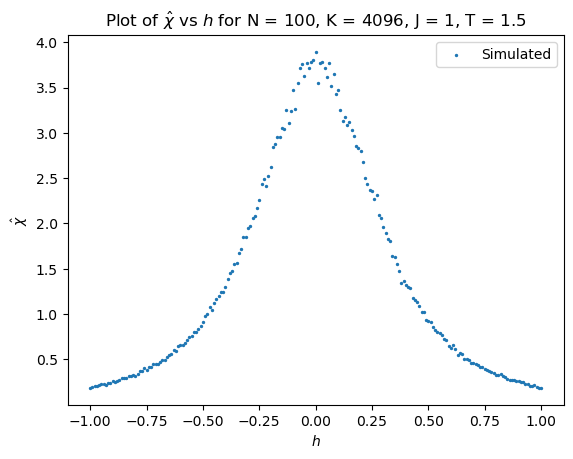

In [462]:
fig_Var = plt.figure()

plt.scatter(h, Var_M_h, s=2, label = "Simulated")

# popt_chi, pcov_chi = curve_fit(chi_analyt, h, Var_M_h)
# perr_chi = np.sqrt(np.diag(pcov_chi)) # compute one stdev error on params
# plt.plot(h, chi_analyt(h, *popt_chi), 'r-', 
#          label = r"Fit: $J = %.3f \pm %.3f$"
#          % (popt_chi, perr_chi))

plt.title(r"Plot of $\hat{\chi}$ vs $h$ for N = %i, K = %i, J = %i, T = %.1f" %(N, K, J, T))
plt.xlabel(r"$h$")
plt.ylabel(r"$\hat{\chi}$")
plt.legend(loc = "upper right")

plt.show()

#### Error analysis $(h = 0, J = 1)$

Estimate error bars from the variances of $\bar{M}$ and $\hat{\chi}$ across several simulations.

In [463]:
# '''
# Estimated execution times
# ~3 min (N = 100, K = 4096)
# '''

# t_start = time.time()
# trials = 10
# # beta is from previously loaded/simulated data
# M_h_per_trial = np.full((trials, len(h)), float("nan"))
# # M_beta_per_trial[i][j] = (i-1)th trial for beta = beta[j]
# Var_M_h_per_trial = np.full((trials, len(h)), float("nan"))
# # Var_M_beta_per_trial[i][j] = (i-1)th trial for beta = beta[j]

# for i in range(trials):
#     for H in range(len(h)):
#         # Initialise configuration array
#         Sigma = np.ones(N)
#         M_Sigma = np.full(K, float("nan"))
#         # Warm-up
#         UpdateConfig(n_w * N, Sigma, h[H], J, T)

#         # Sampling
#         for k in range(K):
#             M_Sigma[k] = M_config(Sigma)
#             UpdateConfig(n_I * N, Sigma, h[H], J, T)

#         # Store results per beta
#         M_h_per_trial[i][H] = M_bar_sys(M_Sigma)
#         Var_M_h_per_trial[i][H] = chi_hat(M_Sigma, N)

# t_end = time.time()

# t_elapsed = t_end - t_start
# print("Execution time = ", t_elapsed, " seconds.")

It is highly recommended to save data to load up for later use due to the time it can take to run this simulation.

In [464]:
# # Save data as .npy file for later use to save time if desired
# file_name_h = "data_N%i_K%i_J%i_T%.1f_h.npy" %(N, K, J, T)
# file_name_M_multi = "data_N%i_K%i_J%i_T%.1f_M_multi.npy" %(N, K, J, T)
# file_name_Var_M_multi = "data_N%i_K%i_J%i_T%.1f_Var_M_multi.npy" %(N, K, J, T)
# np.save(file_name_h, h)
# np.save(file_name_M_multi, M_h_per_trial)
# np.save(file_name_Var_M_multi, Var_M_h_per_trial)

#### Plots including error bars $(h = 0, J = 1)$

In [465]:
# Load data from .npy file if required
N = 100
K = 4096
h = np.load("data_N%i_K%i_J%i_T%.1f_h.npy" %(N, K, J, T))
M_h_per_trial = np.load("data_N%i_K%i_J%i_T%.1f_M_multi.npy" %(N, K, J, T))
Var_M_h_per_trial = np.load("data_N%i_K%i_J%i_T%.1f_Var_M_multi.npy" %(N, K, J, T))

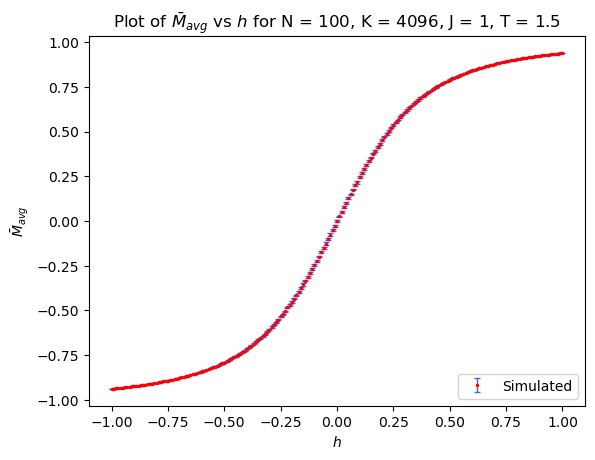

In [466]:
M_avg = np.average(M_h_per_trial, axis = 0)
M_error = np.std(M_h_per_trial, axis = 0)

fig_M_bar_error = plt.figure()

plt.errorbar(h, M_avg, yerr = M_error,  ls = 'none',
             fmt = 'ro', markersize = 1.5,
             elinewidth = 1, ecolor = 'royalblue', capsize = 2,
             label = "Simulated")

plt.title(r"Plot of $\bar{M}_{avg}$ vs $h$ for N = %i, K = %i, J = %i, T = %.1f" %(N, K, J, T))
plt.xlabel(r"$h$")
plt.ylabel(r"$\bar{M}_{avg}$")
plt.legend(loc = "lower right")

plt.show()

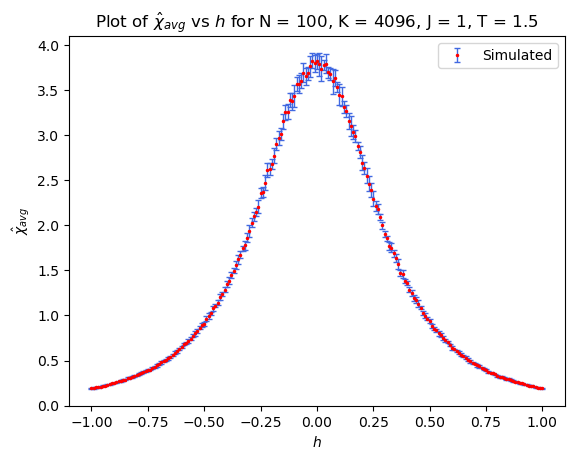

In [467]:
Var_M_avg = np.average(Var_M_h_per_trial, axis = 0)
Var_M_error = np.std(Var_M_h_per_trial, axis = 0)

fig_Var_error = plt.figure()

plt.errorbar(h, Var_M_avg, yerr = Var_M_error,  ls = 'none',
             fmt = 'ro', markersize = 1.5,
             elinewidth = 1, ecolor = 'royalblue', capsize = 2,
             label = "Simulated")

plt.title(r"Plot of $\hat{\chi}_{avg}$ vs $h$ for N = %i, K = %i, J = %i, T = %.1f" %(N, K, J, T))
plt.xlabel(r"$h$")
plt.ylabel(r"$\hat{\chi}_{avg}$")
plt.legend(loc = "upper right")

plt.show()